**NB :** Ceci est un notebook interactif. Vous pouvez modifier les valeurs ou intéragir avec les graphiques.

Pensez à (re)valider les cellules si ça n'est pas fait automatiquement au lancement : **Maj+Entrer** ou **Cell >> Run All**

In [27]:
%%html
<script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events),on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
</script>

In [77]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, Math,HTML
from scipy.stats import norm,lognorm
from itertools import permutations
from scipy import linalg,optimize
from pyvalem.formula import Formula 

# Echantillonnage : Dissection de la formule simplifiée de Pierre Gy

La formule simplifiée de Pierre Gy permet d'estimer la variance de l'erreur fondamentale lors d'un échantillonnage.

$\large \sigma_{EF}^2=\left(\frac{1}{M_e}-\frac{1}{M_L}\right) 𝑐 𝑔 𝑙 𝑓 𝑑^3 $

Elle permet de se concentrer sur l'effet :
1. de la masse de l'échantillon prélevé ($M_e$) et 
2. la maille granulométrique prélevée (représentée par les facteurs $𝑔 𝑙 𝑓 𝑑^3$, voir détails ci-dessous)
3. la teneur n'influe finalement que sur le paramètre $c$

## Explications détaillées

Dans cette formule. on considère la teneur d'un élément chimique ($t_e$) présents au sein d'une phase minérale ($A$) prise dans une gangue qui regroupe tout le reste ($G$). 

Les blocs ci-dessous vont vous permettre de comprendre la signification et l'impact de chacun de ces facteurs :
* $\sigma_{EF}^2$ est la variance de l'erreur fondamentale (relative).<br>Cette variance relative permet de déduire un écart-type absolu $\sigma=t_A\sqrt{\sigma_{EF}^2}$, en le rapportant à la teneur en minéral $t_A$.
<br>Un interval de confiance de $\pm 2 \sigma$ permet d'encadrer 95% des incertitudes.<br>La valeur réelle a donc 95% de chance d'être dans une gamme $\left[t_A-2\sigma,t_A+2\sigma\right]$
* $M_e$ et $M_L$ représentent les masses de l'échantillon et du lot estimé. En pratique, on considèrera souvent le lot comme très grand par rapport à l'échantillon. donc on peut en faire abstraction : $\left(\frac{1}{M_e}-\frac{1}{M_L}\right)\approx\frac{1}{M_e}$ 
* $c$ : est un facteur de composition : $c =\left(\frac{1-t_A}{t_A}\right)\big[(1-t_A)\rho_A + t_A \rho_G\big]$. où $\rho_A$ est la masse volumique du minéral d'intérêt et $\rho_G$ celle de la gangue
* $g$ : est un facteur de distribution qui prend en compte la répartition de la granulométrie. Ce facteur dépend des dimensions $d_{5\%}$ et $d_{95\%}$.
 * Cette notation $d_{i\%}$ décrit la taille de maille retenant $i\%$ de sa masse. 
 * $d_{5\%}$ est donc une taille assez grande qui ne retient que les 5%(en masse) des grains les plus gros 
 * $d_{95\%}$ est une taille plus petite qui retient 95% de la masse, donc quasiment l'ensemble des grains des grains. sauf les 5\% de masse représentée par la fraction la plus fine.
* $l$ : est le facteur de libération. Il permet de tenir compte du fait que les minéraux d'intérêts (A) sont au départ pris dans la gangue. Plus les grains sont broyés fins et plus il y a de chance que le minéraux A se retrouvent complètement libéré de leur gangue. 
 * $d_l$ : est la dimension de libération commençante. i.e., la taille à laquelle les particules auront libéré 5% des minéraux A. En d'autres termes. si on réduit des grains à cette taille de manière homogène. 5% de la masse des minéraux A sera libre. 95% sera toujours attaché à des minéraux de gangue.
 * $l$ varie entre 0 et 1 : à 0 la libération est nulle, à 1 elle est totale
 * si $d_{5\%}\leq d_l$, on prendra : $l=1$ (95% des grains doivent être plus fin que $d_l$ donc 95% de A est libéré, on considère qu'on a atteint la maille de libération)
 * si $d_{5\%}> d_l$, on considèrera : $l=\sqrt{\frac{d_l}{d_{5\%}}}$ (moins de 95% des A sont libres la libération n'est donc que trop partielle, ce dont tient compte $l$)
* $f 𝑑^3$ : rend compte du volume des particules : 
 * $d$ correspond au diamètre des particules les plus grossières, en pratique on prend $d=d_{5\%}$.
 * $f$ est un facteur de forme. C'est le coefficient à appliquer pour passer d'une taille au cube à un volume :
  * pour des particules cubiques : $d$ représente le côté, donc le volume est $d^3$, ce qui correspond à $f=1$
  * pour des particules sphériques : $d$ représente le diamètre, donc le volume est $\frac{4}{3}\pi\left(\frac{d}{2}\right)^3 = \frac{\pi}{6}d^3$, ce qui correspond à $f=\frac{\pi}{6}=0.5236$
  * pour des particules allongées, e.g., l'or alluvial, on pourra prendre $f=0.2$
  * par défaut, si on ne connait pas la forme des particules on considèrera qu'elles sont proches de sphère : $f=0.5$

## Visualisation de l'effet des différents paramètres

### Visualisation de l'effet de $\sigma_{EF}^2$ et des teneurs $t_A$ et $t_e$
$\sigma_{EF}^2$ est la variance de l'erreur fondamentale (relative).
<br>Cette variance relative permet de déduire un écart-type absolu $\sigma=t_A\sqrt{\sigma_{EF}^2}$. en le rapportant à la teneur en minéral $t_A$.

Un interval de confiance de $\pm 2 \sigma$ permet d'encadrer 95% des incertitudes. La valeur réelle a donc 95% de chance d'être dans une gamme $\left[t_A-2\sigma.t_A+2\sigma\right]$

In [2]:
def compute_std(tA,var_EF):
    return tA*np.sqrt(var_EF)
def compute_confidence_range(tA,std,confidence):
    n=norm().isf((1-confidence/100)/2)
    return [tA-n*std,tA+n*std]

In [3]:
def annotate_sigma(dist,n_sigma,ax):
    height = 0.16*(1-(abs(n_sigma)-1)/2)+0.02
    ax.annotate("", xy=(dist.mean()-n_sigma*dist.std(), height), xytext=(dist.mean(), height),
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
    ax.text(dist.mean()-n_sigma*dist.std()/2, height, r'{}$\sigma$'.format(abs(n_sigma) if abs(n_sigma)>1 else ""),
             {'color': 'black', 'fontsize': 16, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.2)})

perc={}
perc[1]=68
perc[2]=95
perc[3]=99.7
def annotate_perc(dist,n_sigma,ax):
    height = 0.15*(1-(abs(n_sigma)-1)/2)+0.005
    ax.annotate("", xy=(dist.mean()-n_sigma*dist.std(), height),
                 xytext=(dist.mean()+n_sigma*dist.std(), height),
                 arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))

    ax.text(dist.mean(), height, "{}%".format(perc[n_sigma]),
             {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.2)})    

@interact(te=widgets.FloatSlider(min=0.001,max=0.999,step=0.001,value=0.1,continuous_update=False,description="$t_{e|A}$ : la teneur en élément cible dans le minéral d'intérêt"),
          tA=widgets.FloatSlider(min=0.001,max=0.999,step=0.001,value=0.1,continuous_update=False,description="$t_A$ : la proportion massique de minéral d'intérêt dans le lot"),
          EF_perc=widgets.IntSlider(min=1,max=100,step=1,value=10,continuous_update=False,description="$EF_{\%}$ : l'erreur fondamentale en %"),
          confidence=widgets.FloatSlider(min=50,max=99.99,value=95.45,step=0.01,continuous_update=False,description="Le niveau de confiance (e.g.. 95%)"),
          show_switch=widgets.Dropdown(options=["minéral porteur","élément d'intérêt"],description='Teneur en :'))
def interact_confidence_range(te,tA,EF_perc,confidence,show_switch):
    fig,ax = plt.subplots(1,2)

    N_4_2 = norm(loc=4,scale=2)
    range_min,range_max = [-3,11]
    x= np.linspace(range_min,range_max,100)
    ax[0].plot(x,N_4_2.pdf(x))
    ax[0].axvline(x=N_4_2.mean(),color='r')
    ax[0].axvline(x=N_4_2.mean()-N_4_2.std(),color='r',linestyle="--",ymax=0.9)
    ax[0].axvline(x=N_4_2.mean()+N_4_2.std(),color='r',linestyle="--",ymax=0.9)
    ax[0].axvline(x=N_4_2.mean()-2*N_4_2.std(),color='gray',linestyle="--",ymax=0.5)
    ax[0].axvline(x=N_4_2.mean()+2*N_4_2.std(),color='gray',linestyle="--",ymax=0.5)
    ax[0].axvline(x=N_4_2.mean()-3*N_4_2.std(),color='gray',linestyle="--",ymax=0.125)
    ax[0].axvline(x=N_4_2.mean()+3*N_4_2.std(),color='gray',linestyle="--",ymax=0.125)
    annotate_sigma(N_4_2,-1,ax[0])
    annotate_sigma(N_4_2,1,ax[0])
    annotate_sigma(N_4_2,-2,ax[0])
    annotate_sigma(N_4_2,2,ax[0])
    annotate_sigma(N_4_2,-3,ax[0])
    annotate_sigma(N_4_2,3,ax[0])
    annotate_perc(N_4_2,1,ax[0])
    annotate_perc(N_4_2,2,ax[0])
    annotate_perc(N_4_2,3,ax[0])
    
    ax[0].set_title("Gamme d'incertitude en fonction du nombre d'écart-type")

    tA = tA if show_switch == "minéral porteur" else tA*te
    scale_factor = 1/100
    sigma = tA*EF_perc * scale_factor
    range_min,range_max = compute_confidence_range(tA,sigma,confidence)
    N = norm(loc=tA,scale=sigma)
    x= np.linspace(tA-4*sigma,tA+4*sigma,1000)
    pdf = N.pdf(x)
    ax[1].set_ylim(0,1.05*N.pdf(tA))
    ax[1].plot(x / scale_factor,pdf,label="Distribution de probabilité de "+r"$t_A$")
    ax[1].axvline(x=tA / scale_factor,color='g',linestyle="-",ymax=0.99,label="Estimation")
    ax[1].axvline(x=range_min / scale_factor,color='r',linestyle="--",ymax=0.9,label="Interval de confiance à {}".format(confidence))
    ax[1].axvline(x=range_max / scale_factor,color='r',linestyle="--",ymax=0.9)
    
    handles,labels = ax[1].get_legend_handles_labels()
    handles.append(patches.Patch(color='none', label="Erreur fondamentale (EF) : {}%".format(EF_perc)))
    handles.append(patches.Patch(color='none', label="Variance d'erreur fondamentale : {}={:.3f}".format(r"$\sigma_{EF}2$",(EF_perc/100)**2 )))
    ax[1].legend(handles=handles)

    graph_max = max(0.5 if show_switch == "minéral porteur" else 0.1,1.5*range_max)/scale_factor
    ax[1].set_xlim(0,graph_max)
    ax[1].set_xticks(np.arange(0,graph_max,10 if show_switch == "minéral porteur" else 1))
    ax[1].set_xlabel("Teneur en "+show_switch+" (en %masse)")
    
    ax[1].set_title("Gamme d'incertitude en teneur ({})".format(show_switch))
    
    fig.set_size_inches((16,4))

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description="$t_{e|A}$ : la teneur en él…

Faites varier l'interval de confiance et les teneurs pour voir leurs influences sur l'erreur absolue.

### Visualisation de l'effet de la masse de l'échantillon $M_e$

$M_e$ et $M_L$ représentent les masses de l'échantillon et du lot estimé.<br>En pratique. on considèrera souvent le lot comme très grand par rapport à l'échantillon. donc on peut en faire abstraction : $\left(\frac{1}{M_e}-\frac{1}{M_L}\right)\approx\frac{1}{M_e}$

In [4]:
def sample_mass_factor(Me,ML=None):
    if ML is None:
        return 1/Me
    else:
        return 1/Me - 1/ML
def mass_factor_simplification_overestimate_perc(Me,ML):
    return (1/ML)/(1/Me - 1/ML)*100
def compute_var_EF(Me,ML=None,c=1,g=1,l=1,f=1,d=1):
    return sample_mass_factor(Me,ML)*c*g*l*f*(d**3)

In [5]:
@interact(ML=widgets.FloatLogSlider(min=0,max=6,step=0.2,value=100,description="Masse du lot",continuous_update=False))
def interact_mass_effect(ML):
    Me_x = np.linspace(1,0.95*ML,100)

    fig,ax = plt.subplots(1,2)
    ax[0].set_title("Effet de la masse de l'échantillon")
    ax[0].set_ylabel("Erreur fondamentale relative normalisée (%)")
    ax[0].plot(Me_x,compute_std(1,compute_var_EF(Me_x)),label="sans considérer la masse du lot")
    ax[0].plot(Me_x,compute_std(1,compute_var_EF(Me_x,ML=ML)),label="en considérant un lot de {}g".format(ML))
    ax[0].set_xlabel("Masse de l'échantillon (Me) en g")
    ax[0].set_yticks(np.arange(0.1,1.10,0.1))
    ax[0].set_yticklabels(np.arange(10,110,10))
    ax[0].legend()
    
    Me_x = np.linspace(1,0.75*ML,100)
    ax[1].set_title("Surestimation de l'erreur du à la simplification de "+r"$M_L$: $\frac{1/M_L}{1/M_e - 1/M_L}$")
    ax[1].set_ylabel("Portion de l'Erreur fondamentale surestimée")
    overestimates = mass_factor_simplification_overestimate_perc(Me_x[:-1],ML)
    ax[1].plot(Me_x[:-1],overestimates)
    ax[1].set_xlabel("Masse de l'échantillon (Me) en g")
    ax[1].set_yticks(np.append([0,20,50,75],np.arange(100,overestimates.max(),100)))
    
    fig.set_size_inches((16,4))
    

interactive(children=(FloatLogSlider(value=100.0, continuous_update=False, description='Masse du lot', max=6.0…

L'augmentation de la masse d'échantillon fait rapidement chuter l'erreur fondamental (i.e.. l'incertitude).

Le fait d'ignorer la masse du lot est négligeable tant que l'échantillon reste petit par rapport au lot.<br>
A combien s'élève cette surestimation pour un échantillon représentant 10% de la masse du lot ?

### Visualisation de l'effet du facteur de composition $c$

Le facteur de composition $c$ prend en compte la proportion de minéraux d'intérêt dans l'ensemble 

$c =\left(\frac{1-t_A}{t_A}\right)\big[(1-t_A)\rho_A + t_A \rho_G\big]$. où :
* $t_A$ est la proportion massique de minéraux d'intéret
* $\rho_A$ est la masse volumique du minéral d'intérêt
* $\rho_G$ est la masse volumique de la gangue

In [6]:
def compute_composition_factor(tA,rhoA,rhoG):
    return (1-tA)/tA*((1-tA)*rhoA + tA*rhoG)

In [7]:
@interact(rho_A = widgets.FloatSlider(min=1,max=15,step=0.1,value=5,description=r"$\rho_A$: Masse volumique A (g/cm^3)",continuous_update=False),
         rho_G = widgets.FloatSlider(min=1,max=15,step=0.1,value=3,description=r"$\rho_G$: Masse volumique G (g/cm^3)",continuous_update=False))
def interact_composition_factor(rho_A,rho_G):
    tA_x = np.linspace(0,1,100)[1:]
    plt.plot(tA_x,compute_composition_factor(tA_x,rho_A,rho_G))
    plt.title("Effet du facteur de composition")
    plt.ylabel("Facteur de composition ($c$)")
    plt.xlabel("Proportion massique de A dans le lot")

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='$\\rho_A$: Masse volumique …

Attention. $t_A$ est bien la proportion massique de minéraux et non de l'élement chimique recherché. Il faut mettre ces deux quantités en relation par : 

$t_e = t_{e|A}\cdot t_{A}$ \hspace{2cm} $ t_A = \frac{t_{e}}{t_{e|A}}$. \hspace{2cm} avec :<br> 
* $t_e$ : la teneur massique en élément $e$ dans le matériau
* $t_A$ : la teneur massique de minéraux $A$ dans le matériau
* $t_{e|A}$ : la teneur massique (i.e.. proportion en masse) de l'élément $e$ dans $A$



$t_{e|A}$ peut s'estimer grâce à la formule chimique du minéral porteur et aux masses molaires. Par exemple pour la chalcopyrite ($CuFeS_2$):

$t_{Cu|CuFeS_2} = \frac{\mathrm{M}_{Cu}}{\mathrm{M}_{Cu}+\mathrm{M}_{Fe}+2\cdot \mathrm{M}_S}$

### Visualisation de l'effet du facteur de granulométrie $g$

$g$ est un facteur de distribution qui prend en compte la répartition de la granulométrie.

Ce facteur dépend des dimensions $d_{5\%}$ et $d_{95\%}$.
 * Cette notation $d_{i\%}$ décrit la taille de maille retenant $i\%$ de sa masse. 
 * $d_{5\%}$ est donc une taille assez grande qui ne retient que les 5%(en masse) des grains les plus gros 
 * $d_{95\%}$ est une taille plus petite qui retient 95% de la masse, donc quasiment l'ensemble des grains des grains, sauf les 5% de masse représentée par la fraction la plus fine.
 
$g$ est fixé suivant ce tableau :

| $d_{5\%} / d_{95\%}$ | $g$ | 
|----------------------|-----|
|   >4  | 0.4    |
|   2< ... < 4  | 0.5    |
|   1< ... < 2  | 0.75    |
|    1 | 1|

Si $d_{5\%}$ et $d_{95\%}$ ne sont pas connus on prendra $g = 0.25$

In [8]:
def compute_d(granulo,mass,perc):
    cum = np.cumsum(mass)
    cum = cum/cum[-1]
    perc = (100-perc)/100
    first = np.argwhere(cum > perc).ravel()[0]
    if first>0:
        seg = first-1
        alpha = (perc-cum[seg])/(cum[seg+1]-cum[seg])
        return [(1-alpha)*granulo[seg] + alpha*granulo[seg+1],
                (1-alpha)*mass[seg] + alpha*mass[seg+1]]
    else:
        return [granulo[0],mass[0]]

def compute_g(d5=None,d95=None):
    if d5 is None or d95 is None:
        return 0.25
    ratio  = d5/d95
    if ratio == 1:
        return 1
    elif ratio < 2:
        return 0.75
    elif ratio < 4:
        return 0.5
    else:
        return 0.4

In [9]:
@interact(d5=widgets.IntSlider(min=1,max=100,value=90,step=1),
         d95=widgets.IntSlider(min=1,max=100,value=10,step=1))
def interact_g(d5,d95):
    if d5<d95:
        print("d5% doit être plus grand que d95%")
    else:
        print("Le facteur de granulométrie g vaut :",compute_g(d5,d95))

interactive(children=(IntSlider(value=90, description='d5', min=1), IntSlider(value=10, description='d95', min…

In [10]:
@interact(perc=widgets.IntSlider(min=1,max=99,step=1,value=50,description=r"$d_{\%}$",continuous_update=False))
def interact_d(perc):
    granulo_limits = np.array([0,0.04,0.08,0.16,0.315,0.63,1.25,2.5,5,12.5,20,40])
    granulo_center = 0.5*(granulo_limits[:-1]+granulo_limits[1:])
    granulo_mass = np.array([198,150,184,106,89.2,98,83.7,23.7,14.8,13.3,39.3])[::-1]
    plt.semilogx(granulo_center,granulo_mass)
    plt.title("Répartition granulométrique")
    plt.xlabel("Granulométrie (mm)")
    plt.ylabel("Masse (g)")

    d5,mass5 = compute_d(granulo_center,granulo_mass,5)
    plt.plot([d5,d5],[0,mass5],"k--")
    plt.text(d5,mass5*1.15,r"$d_{"+"{}".format(5)+"\%}$",
             {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.15)})
    d95,mass95 = compute_d(granulo_center,granulo_mass,95)
    plt.plot([d95,d95],[0,mass95],"k--")
    plt.text(d95,mass95*1.15,r"$d_{"+"{}".format(95)+"\%}$",
             {'color': 'black', 'fontsize': 12, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.15)})
    
    d,mass = compute_d(granulo_center,granulo_mass,perc)
    plt.plot([d,d],[0,mass])
    granulo_fill = np.append([d],granulo_center[granulo_center>d])
    mass_fill = np.append([mass],granulo_mass[granulo_center>d])
    plt.fill_between(granulo_fill,mass_fill,0)
    plt.text(d,mass*1.15,r"$d_{"+"{}".format(perc)+"\%}$",
             {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
              'bbox': dict(boxstyle="round", fc="white", pad=0.2)})


interactive(children=(IntSlider(value=50, continuous_update=False, description='$d_{\\%}$', max=99, min=1), Ou…

Attention, ce paramètre peut être contre-intuitif. C'est bien la maille qui retient n% de la masse.

$d_{5\%}$ est donc une borne relativement haute de la gamme de granulométrie, alors que $d_{95\%}$ représente la taille des plus petites particules.

### Visualisation de l'effet du facteur de libération $l$

$l$ : est le facteur de libération. Il permet de tenir compte du fait que les minéraux d'intérêts (A) sont au départ pris dans la gangue. Plus les grains sont broyés fins et plus il y a de chance que le minéraux A se retrouvent complètement libéré de leur gangue. 
 * $d_l$ : est la dimension de libération commençante. i.e., la taille à laquelle les particules auront libéré 5% des minéraux A. En d'autres termes. si on réduit des grains à cette taille de manière homogène. 5% de la masse des minéraux A sera libre. 95% sera toujours attaché à des minéraux de gangue.
 * $l$ varie entre 0 et 1 : à 0 la libération est nulle, à 1 elle est totale
 * si $d_{5\%}\leq d_l$, on prendra : $l=1$ (5% des grains doivent être plus gros que $d_l$ donc 95% de A est libéré , on considère qu'on a atteint la maille de libération)
 * si $d_{5\%}> d_l$, on considèrera : $l=\sqrt{\frac{d_l}{d_{5\%}}}$ (moins de 5% des A sont libres la libération n'est donc que trop partielle, ce dont tient compte $l$)

Le broyage permet de réduire la taille des grains et diminue donc $d_{5\%}$.

In [11]:
def compute_liberation_factor(d5,dl):
    return np.where(d5<=dl,1,np.sqrt(dl/d5))

In [12]:
@interact(dl=widgets.FloatLogSlider(min=-3,max=3,value=1,step=0.1,description="dl: Maille de libération commençante (mm)",continuous_update=False),
         d5=widgets.FloatLogSlider(min=-3,max=3,value=2,step=0.1,description="d5 (mm)",continuous_update=False))
def interact_liberation(dl,d5):
    d_x = 10**np.linspace(-3,3,1000)
    plt.semilogx(d_x, compute_liberation_factor(d_x,dl))
    plt.title("Effet du facteur de libération")
    plt.ylabel("Contribution de l")
    plt.xlabel("$d_{5\%}$ (mm)")
    plt.ylim(0,1.05)
    plt.axvline(x=dl,color='r',linestyle="--",ymax=0.98,label="dl")
    
    l=compute_liberation_factor(d5,dl)
    plt.scatter(d5,l,color="r")
    plt.semilogx([d5,d5],[0,l],"r-",label="$d_{5\%}$") 
    
    handles,labels = plt.gca().get_legend_handles_labels()
    handles.append(patches.Patch(color='none', label="l={:0.2f}".format(l)))
    plt.legend(handles=handles)


interactive(children=(FloatLogSlider(value=1.0, continuous_update=False, description='dl: Maille de libération…

### Visualisation de l'effet volumetrique

$f 𝑑^3$ : rend compte du volume des particules : 
 * $d$ correspond au diamètre des particules le splus fines, en pratique on prend $d=d_{95\%}$.
 * $f$ est un facteur de forme. C'est le coefficient à appliquer pour passer d'une taille au cube à un volume :
  * pour des particules cubiques : $d$ représente le côté, donc le volume est $d^3$, ce qui correspond à $f=1$
  * pour des particules sphériques : $d$ représente le diamètre, donc le volume est $\frac{4}{3}\pi\left(\frac{d}{2}\right)^3 = \frac{\pi}{6}d^3$, ce qui correspond à $f=\frac{\pi}{6}=0.5236$
  * pour des particules allongées, e.g., l'or alluvial, on pourra prendre $f=0.2$
  * par défaut, si on ne connait pas la forme des particules on considèrera qu'elles sont proches de sphère : $f=0.5$

In [13]:
shape_factor={
    "cube":1,
    "sphere":np.pi/6,
    "flake":0.2,
    "default":0.5
}
def compute_volumetric_effect(d,shape="default"):
    return shape_factor[shape]*d**3

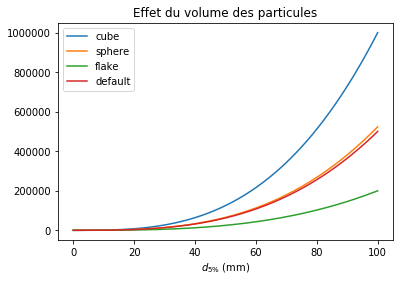

In [14]:
shape=["cube","sphere","flake","default"]
d_x = 10**np.linspace(-3,2,1000)
plt.xlabel("$d_{5\%}$ (mm)")
plt.title("Effet du volume des particules")
for shape_i in shape:
    plt.plot(d_x,compute_volumetric_effect(d_x,shape_i),label=shape_i)
plt.legend()


# Applications de la formule de Gy simplifiée

In [126]:
def transform_grade_to_mineral(te,element,mineral,verbose=True):
    molar_mass_element = Formula(element).rmm
    molar_mass_mineral = Formula(mineral).rmm
    stoechio = Formula(mineral).atom_stoich[element]
    
    tA = te*molar_mass_mineral*stoechio/molar_mass_element
    if verbose: print("Pour une teneur en Cu de {:.2f}% on a une teneur en Chalcopyrite de {:.2f}%".format(te*100,tA*100))
    return tA

def compute_factors(d5,tA,rhoA,rhoG,dl,d95=None,shape="default",ML=None,verbose=True):
    if verbose: print("Calculs des facteurs contribuants à l'erreur fondamentale")
    composition_factor = compute_composition_factor(tA=tA,rhoA=rhoA,rhoG=rhoG)
    if verbose: print("  Composition factor: c={:.4f}".format(composition_factor))
    granulo_factor = compute_g(d5,d95)
    if verbose: print("  Granulometric factor: g={:.4f}".format(granulo_factor))
    liberation_factor = compute_liberation_factor(d5=d5,dl=dl)
    if verbose: print("  Liberation factor: l={:.4f}".format(liberation_factor))
    
    volumetric_factor = compute_volumetric_effect(d5,shape)
    if verbose: print("  Shape factor: f={}".format(shape_factor[shape]))
    if verbose: print("  Volumetric factor: fd**3={:.4f}".format(volumetric_factor))
    
    return composition_factor * granulo_factor * liberation_factor * volumetric_factor

def confidence2std(confidence_perc):
    return norm().isf((1-confidence_perc/100)/2)
    
def compute_EF(Me,d5,tA,rhoA,rhoG,dl,d95=None,shape="default",ML=None,verbose=True,confidence_perc=95):
    sample_mass_factor = 1/Me
    lot_mass_factor = 0 if ML is None else 1/ML
    mass_factor = sample_mass_factor - lot_mass_factor
    if verbose: print("Mass factor: 1/Me - 1/ML =",mass_factor)
    
    var_relative = mass_factor * compute_factors(d5,tA,rhoA,rhoG,dl,d95,shape,ML,verbose)
    if verbose:
        print("The estimated relative variance: {}".format(var_relative))
    if verbose: print("Using a confidence interval gathering {}% of possible values".format(confidence_perc))
    n = confidence2std(confidence_perc)
    if verbose: print("This confidence range corresponds to {:.2f} standard deviations".format(n))
    EF = n*np.sqrt(var_relative)
    if verbose: print("The Fondamental Error (EF) is {:0.2f}%".format(EF*100))
    return EF

def compute_sample_mass(EF,d5,tA,rhoA,rhoG,dl,d95=None,shape="default",ML=None,verbose=True,confidence_perc=95):
    """
    EF (%): is the relative error with a confidence interval given by confidence_perc
    d5 (cm): size of the largest particles 
    tA : grade in terms of mineral A
    rhoA and rhoG (g/cm^3): volumetric mass of mineral A and bulk
    dl (cm): liberation size
    result in g
    """
    
    if verbose: print("Using a confidence interval gathering {}% of possible values".format(confidence_perc))
    n = confidence2std(confidence_perc)
    if verbose: print("This confidence range corresponds to {:.2f} standard deviations".format(n))
    var_relative = (EF/n)**2
    if verbose:
        print("With a Fondamental error (EF) of: {}".format(EF))
        print("Target relative variance: {}".format(var_relative))
    
    sample_mass = 1/var_relative * compute_factors(d5,tA,rhoA,rhoG,dl,d95,shape,ML,verbose)
    if verbose:
        if sample_mass >10**6:
            print("Sample mass: {:.3f}t".format(sample_mass/10**6))
        elif sample_mass >10**3:
            print("Sample mass: {:.3f}kg".format(sample_mass/10**3))
        else:
            print("Sample mass: {:.3f}g".format(sample_mass))
    return sample_mass

## Calculs d'incertitude

### Chacopyrite

On considère un minerai de cuivre concassé à 12,5 mm présentant les caractéristiques suivantes :
* la teneur en cuivre ($t_{Cu}$) est de 0.8 % en masse
* le cuivre est porté par la chalcopyrite ($CuFeS_2$)
* les observations minéralogiques montrent que la maille de libération ($dl$) est de 0,01 cm

In [127]:
te = 1/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_1_d5_50 = compute_sample_mass(EF=0.2,d5=50,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 1.00% on a une teneur en Chalcopyrite de 2.89%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=140.0718
  Granulometric factor: g=0.2500
  Liberation factor: l=0.0447
  Shape factor: f=0.5
  Volumetric factor: fd**3=62500.0000
Sample mass: 2.460t


In [128]:
te = 5/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_5_d5_50 = compute_sample_mass(EF=0.2,d5=50,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 5.00% on a une teneur en Chalcopyrite de 14.44%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=23.8607
  Granulometric factor: g=0.2500
  Liberation factor: l=0.0447
  Shape factor: f=0.5
  Volumetric factor: fd**3=62500.0000
Sample mass: 419.093kg


In [129]:
te = 1/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_1_d5_10 = compute_sample_mass(EF=0.2,d5=10,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 1.00% on a une teneur en Chalcopyrite de 2.89%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=140.0718
  Granulometric factor: g=0.2500
  Liberation factor: l=0.1000
  Shape factor: f=0.5
  Volumetric factor: fd**3=500.0000
Sample mass: 44.010kg


In [130]:
te = 5/100
tA = transform_grade_to_mineral(te,"Cu","CuFeS2")
sample_te_5_d5_10 = compute_sample_mass(EF=0.2,d5=10,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)

Pour une teneur en Cu de 5.00% on a une teneur en Chalcopyrite de 14.44%
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
With a Fondamental error (EF) of: 0.2
Target relative variance: 0.03978394599364574
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=23.8607
  Granulometric factor: g=0.2500
  Liberation factor: l=0.1000
  Shape factor: f=0.5
  Volumetric factor: fd**3=500.0000
Sample mass: 7.497kg


In [131]:
te = 5/10**6
tA = te / (50/10**6)
gold_pyrite = compute_EF(Me=100,d5=0.25,tA=tA,rhoA=5,rhoG=3,dl=0.01,d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.01
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=43.2000
  Granulometric factor: g=0.7500
  Liberation factor: l=0.2000
  Shape factor: f=0.5
  Volumetric factor: fd**3=0.0078
The estimated relative variance: 0.0005062500000000001
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 2.26%


In [141]:
te = 5/10**6
tA = te 
gold_pyrite_EF = compute_EF(Me=100,d5=0.25,tA=tA,rhoA=19,rhoG=3,dl=0.001,shape="flake",d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.01
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=3799965.0001
  Granulometric factor: g=0.7500
  Liberation factor: l=0.0632
  Shape factor: f=0.2
  Volumetric factor: fd**3=0.0031
The estimated relative variance: 5.632755201175648
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 237.98%


[-1.832139911087989e-05, 2.832139911087989e-05]

In [145]:
te = 5/10**6
tA = te 
gold_pyrite_EF = compute_EF(Me=4000,d5=0.25,tA=tA,rhoA=19,rhoG=3,dl=0.001,shape="flake",d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.00025
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=3799965.0001
  Granulometric factor: g=0.7500
  Liberation factor: l=0.0632
  Shape factor: f=0.2
  Volumetric factor: fd**3=0.0031
The estimated relative variance: 0.14081888002939122
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 37.63%


In [147]:
te = 5/10**6
tA = te 
gold_pyrite_EF = compute_EF(Me=100,d5=0.05,tA=tA,rhoA=19,rhoG=3,dl=0.001,shape="flake",d95=0.2,verbose=True,confidence_perc=68.4)

Mass factor: 1/Me - 1/ML = 0.01
Calculs des facteurs contribuants à l'erreur fondamentale
  Composition factor: c=3799965.0001
  Granulometric factor: g=0.7500
  Liberation factor: l=0.1414
  Shape factor: f=0.2
  Volumetric factor: fd**3=0.0000
The estimated relative variance: 0.10076178824355406
Using a confidence interval gathering 68.4% of possible values
This confidence range corresponds to 1.00 standard deviations
The Fondamental Error (EF) is 31.83%


## Plan d'échantillonnage

In [ ]:
compute_sample_mass(EF=0.2,d5=10,tA=tA,rhoA=4.2,rhoG=3,dl=0.1,verbose=True,confidence_perc=68.4)









